In [78]:
import tensorflow as tf
import random
import os

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'


In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load datasets
train_df = pd.read_csv("C:/Users/bhagy/OneDrive/Desktop/Semester 4/FDA/Time Series/train.csv")
stores_df = pd.read_csv("C:/Users/bhagy/OneDrive/Desktop/Semester 4/FDA/Time Series/stores.csv")
features_df = pd.read_csv("C:/Users/bhagy/OneDrive/Desktop/Semester 4/FDA/Time Series/features.csv")

# Convert date column to datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
features_df["Date"] = pd.to_datetime(features_df["Date"])

# Merge train with features and stores
merged = pd.merge(train_df, features_df, on=["Store", "Date", "IsHoliday"])
merged = pd.merge(merged, stores_df, on="Store")

# Group total weekly sales across all stores + depts (for simplicity)
total_sales = merged.groupby("Date")["Weekly_Sales"].sum().reset_index()

# Normalize the sales
scaler = MinMaxScaler()
total_sales["Scaled_Sales"] = scaler.fit_transform(total_sales["Weekly_Sales"].values.reshape(-1, 1))

# Final time series data
data_scaled = total_sales["Scaled_Sales"].values


In [80]:
# Sequence creation
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_lengths = [7, 14, 30, 60]
results = []

for seq_len in sequence_lengths:
    print(f"\n🧪 Training with sequence length: {seq_len}")
    
    X, y = create_sequences(data_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # for LSTM

    # Split into train and test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(seq_len, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Train
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"📉 MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    results.append((seq_len, mae, rmse))



🧪 Training with sequence length: 7


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
📉 MAE: 0.0337 | RMSE: 0.0434

🧪 Training with sequence length: 14


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
📉 MAE: 0.0360 | RMSE: 0.0436

🧪 Training with sequence length: 30


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
📉 MAE: 0.0342 | RMSE: 0.0455

🧪 Training with sequence length: 60


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
📉 MAE: 0.0355 | RMSE: 0.0440



📊 Sequence Length Experiment Results:
   Sequence Length       MAE      RMSE
0                7  0.033617  0.044454
1               14  0.035236  0.042544
2               30  0.035587  0.046622
3               60  0.035818  0.044196


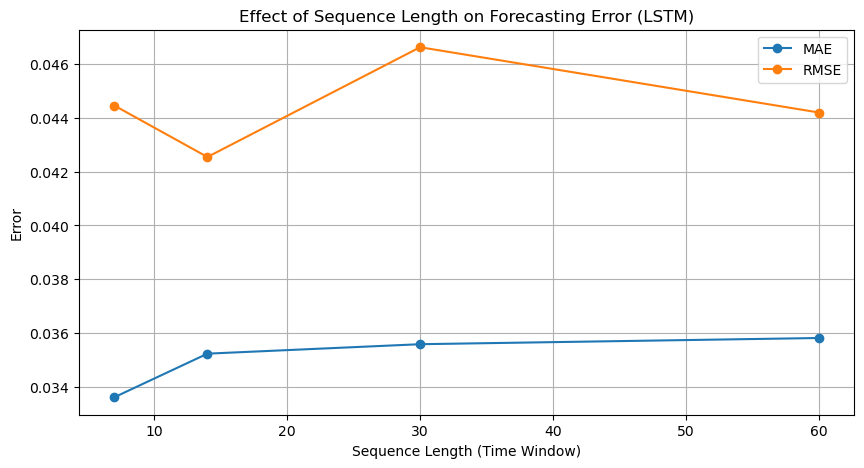

In [58]:
results_df = pd.DataFrame(results, columns=["Sequence Length", "MAE", "RMSE"])
print("\n📊 Sequence Length Experiment Results:")
print(results_df)

# Plot
plt.figure(figsize=(10,5))
plt.plot(results_df["Sequence Length"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["Sequence Length"], results_df["RMSE"], marker='o', label='RMSE')
plt.xlabel("Sequence Length (Time Window)")
plt.ylabel("Error")
plt.title("Effect of Sequence Length on Forecasting Error (LSTM)")
plt.legend()
plt.grid(True)
plt.show()


In [59]:
from tensorflow.keras.layers import GRU

# Use best sequence length based on earlier result
sequence_length = 14

# Create sequences
X, y = create_sequences(data_scaled, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # shape for RNN input

# Split train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

y_pred_lstm = lstm_model.predict(X_test)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [61]:
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

y_pred_gru = gru_model.predict(X_test)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))


C:\Users\bhagy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


In [62]:
print("\n📊 LSTM vs GRU Performance (seq_len = 14)")
print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"GRU  - MAE: {mae_gru:.4f}, RMSE: {rmse_gru:.4f}")



📊 LSTM vs GRU Performance (seq_len = 14)
LSTM - MAE: 0.0361, RMSE: 0.0438
GRU  - MAE: 0.0327, RMSE: 0.0400


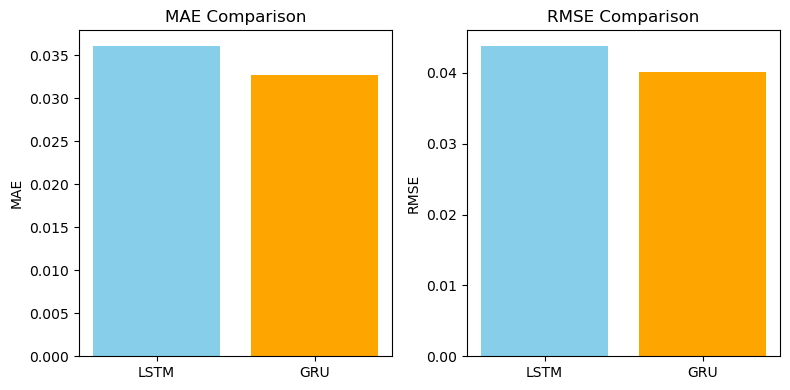

In [63]:
import matplotlib.pyplot as plt

models = ['LSTM', 'GRU']
mae_values = [mae_lstm, mae_gru]
rmse_values = [rmse_lstm, rmse_gru]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color=['skyblue', 'orange'])
plt.title("MAE Comparison")
plt.ylabel("MAE")

plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color=['skyblue', 'orange'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()
